In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle
import metric as me

def extract_patch(image, patch_n, patch_size):
    grid_width = 6
    patch_width, patch_height = patch_size
    patch_n -= 1  # Adjust the patch number to be zero-indexed
    x = (patch_n % grid_width) * patch_width
    y = (patch_n // grid_width) * patch_height
    # Ensure the rectangle is within the bounds of the image
    x = min(x, image.shape[1] - patch_width)
    y = min(y, image.shape[0] - patch_height)
    return image[y:y+patch_height, x:x+patch_width]

def normalize_image(image, min_val=None, max_val=None):
    if min_val is None:
        min_val = np.min(image)
    if max_val is None:
        max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

def combine_patches_blured(parent_folder, key, focus_patch_n):
    patches = []
    focus_patch = None
    for folder_name in os.listdir(parent_folder):
        image_folder = os.path.join(parent_folder, folder_name)
        for file in os.listdir(image_folder):
            file_path = os.path.join(image_folder, file)
            if file_path.endswith('.mat'):
                patch = sio.loadmat(file_path)[key]
                patch_rgb = patch[:, :, [33, 18, 2]]
                patches.append(patch_rgb)

    patches = np.array(patches).reshape((11, 3, *patch_rgb.shape))
    image = normalize_image(np.concatenate(np.concatenate(patches, axis=1), axis=1))
    patch_size = (85, 85)
    focus_patch = extract_patch(image, focus_patch_n, patch_size)

    return image, focus_patch

def combine_patches(image_paths, patch_key_prefix, patch_n):
    patches = []
    focus_patch = None

    data = sio.loadmat(image_paths)
    for i in range(1, 133):  # Assuming there are 33 patches
        patch_key = f"{patch_key_prefix}_{str(i).zfill(2)}_pred"
        if patch_key in data:
            patch = data[patch_key]
            patch_rgb = patch[:, :, [33, 18, 2]]  # Assuming these are the R, G, B channels
            patches.append(patch_rgb)
    
    patches = np.array(patches).reshape((11, 3, *patch_rgb.shape))
    image = normalize_image(np.concatenate(np.concatenate(patches, axis=1), axis=1))

    patch_size = (85, 85)
    focus_patch = extract_patch(image, patch_n, patch_size)

    return image, focus_patch

def show(image, ax, title=None, focus_patch_n=None, patch_size=None, with_border=False):
    ax.axis('off')
    ax.imshow(image)
    if title:
        ax.set_title(title)
    if focus_patch_n and patch_size:  # If the number and size of the focus_patch are provided
        grid_width = 6
        patch_width, patch_height = patch_size
        focus_patch_n -= 1  # Adjust the focus patch number to be zero-indexed
        x = (focus_patch_n % grid_width) * patch_width
        y = (focus_patch_n // grid_width) * patch_height
        # Ensure the rectangle is within the bounds of the image
        x = min(x, image.shape[1] - patch_width)
        y = min(y, image.shape[0] - patch_height)
        rect = Rectangle((x, y), patch_width, patch_height, edgecolor='r', facecolor='none')  # Create a red square
        ax.add_patch(rect)  # Add the square to the image
    if with_border:
        rect = Rectangle((0, 0), image.shape[1]-2, image.shape[0]-1.5, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


def show_images(image_paths, paths, output_path, num):
    filename = os.path.basename(paths)

    image, patch = combine_patches(image_paths, filename, num)
    ref, ref_patch = combine_patches_blured(paths, 'ref', num)
    blurred, blurred_patch = combine_patches_blured(paths, 'blurred', num)
    
    focus_patch_n = num  # Replace with the actual number of the focus_patch
    patch_size = (85, 85)  # Replace with the actual size of the patches
    fig = plt.figure(figsize=(7, 21))

    # Display the main images
    ax1 = fig.add_axes([0.0, 0.5, 0.33, 0.5])  # left, bottom, width, height
    show(ref, ax1, None, focus_patch_n, patch_size)

    ax2 = fig.add_axes([0.35, 0.5, 0.33, 0.5])
    show(blurred, ax2, None, focus_patch_n, patch_size)

    ax3 = fig.add_axes([0.69, 0.5, 0.33, 0.5])
    show(image, ax3, None, focus_patch_n, patch_size)

    # Display the patches
    ax4 = fig.add_axes([0.0, 0.24, 0.33, 0.5])
    show(ref_patch, ax4, with_border=False)

    ax5 = fig.add_axes([0.35, 0.24, 0.33, 0.5])
    show(blurred_patch, ax5, with_border=False)

    ax6 = fig.add_axes([0.69, 0.24, 0.33, 0.5])
    show(patch, ax6, with_border=False)

    # Add labels to the bottom of each patch
    ax4.text(0.5, -0.05, '(a)', transform=ax4.transAxes, horizontalalignment='center', verticalalignment='center')
    ax5.text(0.5, -0.05, '(b)', transform=ax5.transAxes, horizontalalignment='center', verticalalignment='center')
    ax6.text(0.5, -0.05, '(c)', transform=ax6.transAxes, horizontalalignment='center', verticalalignment='center')
    plt.savefig(output_path, format='pdf', bbox_inches='tight')

    plt.show()


In [ ]:
image_paths = '/home/kimado/master/DIP-HyperKite/Experiments/HyperPNN/hico_dataset/N_modules(1)/final_prediction.mat'
paths = '/home/kimado/master/DIP-HyperKite/datasets/hico/H2010026150016.L1B_ISS.nc'
output_path = '/home/kimado/master/HYPSO-1/fig/016-hyperpnn-fus.pdf'
num = 8

show_images(image_paths, paths, output_path, num)

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.colors as colors


def normalize_image(image, min_val=None, max_val=None):
    if min_val is None:
        min_val = np.min(image)
    if max_val is None:
        max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

def normalize_image_diff(image, min_val=None, max_val=None):
    min_val = -0.3132149
    max_val = 0.30004606
    #0.30004606

    normalized = (image - min_val) / (max_val - min_val)
    return normalized 

def combine_patches_blured(parent_folder, key):
    patches = []
    for folder_name in os.listdir(parent_folder):
        image_folder = os.path.join(parent_folder, folder_name)
        for file in os.listdir(image_folder):
            file_path = os.path.join(image_folder, file)
            if file_path.endswith('.mat'):
                patch = sio.loadmat(file_path)[key]
                patch_rgb = patch[:, :, [33, 18, 2]]
                patches.append(patch_rgb)

    patches = np.array(patches).reshape((11, 3, *patch_rgb.shape))
    image = normalize_image(np.concatenate(np.concatenate(patches, axis=1), axis=1))

    return image

def combine_patches(image_paths, patch_key_prefix):
    patches = []

    data = sio.loadmat(image_paths)
    for i in range(1, 133):  # Assuming there are 33 patches
        patch_key = f"{patch_key_prefix}_{str(i).zfill(2)}_pred"
        if patch_key in data:
            patch = data[patch_key]
            patch_rgb = patch[:, :, [33, 18, 2]]  # Assuming these are the R, G, B channels
            patches.append(patch_rgb)

    patches = np.array(patches).reshape((11, 3, *patch_rgb.shape))
    image = normalize_image(np.concatenate(np.concatenate(patches, axis=1), axis=1))

    return image


def show(image, ax, title=None, is_diff=False):
    image = np.rot90(image)  # Rotate the image 90 degrees
    ax.axis('off')
    if is_diff:
        im = ax.imshow(image, cmap='seismic', vmin=-0.3132149, vmax=0.3132149)  # Set vmin and vmax to min and max of image
        plt.colorbar(im, ax=ax, orientation='horizontal', cmap='seismic')
    else:
        im = ax.imshow(image, cmap='seismic')
    if title:
        ax.set_title(title)

def show_difference(image_paths, paths, out):
    filename = os.path.basename(paths)

    image = combine_patches(image_paths, filename)
    ref = combine_patches_blured(paths, 'ref')

    diff = (ref - image)*150

    fig = plt.figure(figsize=(28, 7))  # Adjust the figure size
    ax1 = fig.add_axes([0.0, 0.74, 0.5, 0.33])  # left, bottom, width, height
    show(ref, ax1, None)
    ax2 = fig.add_axes([0.0, 0.37, 0.5, 0.33])
    show(image, ax2, None)
    ax3 = fig.add_axes([-0.0001, -0.14, 0.5, 0.471])
    show(diff, ax3, None, is_diff=True)


    axes = [ax1, ax2, ax3]
    labels = ['Ground truth (RGB)', 'Fused Image (RGB)', 'Difference']

    for ax, label in zip(axes, labels):
        ax.text(0.5, -0.05, label, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')

    plt.savefig(out, format='pdf', bbox_inches='tight')
    plt.show()

ml_fused = {
    #"hyperpnn": '/home/kimado/master/DIP-HyperKite/Experiments/HyperPNN/hico_dataset/N_modules_2/final_prediction.mat',
    "hyperkite": '/home/kimado/master/DIP-HyperKite/Experiments/kitenetwithsk/hico_dataset/N_modules_2/final_prediction.mat',
    "darn": '/home/kimado/master/DIP-HyperKite/Experiments/DHP_DARN/hico_dataset/N_modules_2/final_prediction.mat'
}

blurred_path = ['/home/kimado/master/DIP-HyperKite/datasets/hico/edge_image.nc',
                    '/home/kimado/master/DIP-HyperKite/datasets/hico/H2010026150016.L1B_ISS.nc',
                    '/home/kimado/master/DIP-HyperKite/datasets/hico/H2010154045937.L1B_ISS.nc']
def main_ml():
    for key in ml_fused:
        for path in blurred_path:
            out = f'/home/kimado/master/HYPSO-1/fig/diff_folder/{key}_{os.path.basename(path)}.pdf'
            show_difference(ml_fused[key], path, out)

main_ml()


In [ ]:

import os
import importlib
import pickle
import pandas as pd
import numpy as np

import metric as me

importlib.reload(me)


def normalize_image(image, min_val=None, max_val=None):
    if min_val is None:
        min_val = np.min(image)
    if max_val is None:
        max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

def combine_patches_blured(parent_folder, key):
    patches = []
    for folder_name in os.listdir(parent_folder):
        image_folder = os.path.join(parent_folder, folder_name)
        for file in os.listdir(image_folder):
            file_path = os.path.join(image_folder, file)
            if file_path.endswith('.mat'):
                patch = sio.loadmat(file_path)[key]
                patch_rgb = patch[:, :, :]
                patches.append(patch_rgb)

    patches = np.array(patches).reshape((11, 3, *patch_rgb.shape))
    image = normalize_image(np.concatenate(np.concatenate(patches, axis=1), axis=1))

    return image

def combine_patches(image_paths, patch_key_prefix):
    patches = []

    data = sio.loadmat(image_paths)
    for i in range(1, 133):  # Assuming there are 33 patches
        patch_key = f"{patch_key_prefix}_{str(i).zfill(2)}_pred"
        if patch_key in data:
            patch = data[patch_key]
            patch_rgb = patch[:, :, :]  # Assuming these are the R, G, B channels
            patches.append(patch_rgb)

    patches = np.array(patches).reshape((11, 3, *patch_rgb.shape))
    image = normalize_image(np.concatenate(np.concatenate(patches, axis=1), axis=1))

    return image


def evaluate():

    sbi = 43

    ml_fused = {
        "hyperpnn": '/home/kimado/master/DIP-HyperKite/Experiments/HyperPNN/hico_dataset/N_modules_2/final_prediction.mat',
        "hyperkite": '/home/kimado/master/DIP-HyperKite/Experiments/kitenetwithsk/hico_dataset/N_modules_2/final_prediction.mat',
        "darn": '/home/kimado/master/DIP-HyperKite/Experiments/DHP_DARN/hico_dataset/N_modules_2/final_prediction.mat'
    }

    blurred_path = ['/home/kimado/master/DIP-HyperKite/datasets/hico/edge_image.nc',
                     '/home/kimado/master/DIP-HyperKite/datasets/hico/H2010026150016.L1B_ISS.nc',
                     '/home/kimado/master/DIP-HyperKite/datasets/hico/H2010154045937.L1B_ISS.nc']

    shalg_results = {}
    for name, path in ml_fused.items():
        for paths in blurred_path:
            filename = os.path.basename(paths)
            image = normalize_image(combine_patches(path, filename)).astype(np.float32)
            blurred = normalize_image(combine_patches_blured(paths, 'blurred')).astype(np.float32)
            d_r_scores = []
            d_lambda_scores = []
            qnr_scores = []

            qnr, lam, dsr = me.qnr(blurred, image, sbi)
            qnr_scores.append(qnr)
            d_r_scores.append(dsr)
            d_lambda_scores.append(lam)

            qnr_scores = pd.DataFrame(qnr_scores)
            d_r_scores = pd.DataFrame(d_r_scores)
            d_lambda_scores = pd.DataFrame(d_lambda_scores)

            mean_qnr = np.mean(qnr_scores)
            mean_d_r = np.mean(d_r_scores)
            mean_d_lambda = np.mean(d_lambda_scores)

            shalg_results[name] = {
                "mean_qnr": mean_qnr,
                "mean_d_r": mean_d_r,
                "mean_d_lambda": mean_d_lambda
            }


        with open('ml.pkl', 'wb') as f:
            pickle.dump(shalg_results, f)
evaluate()
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


def normalize_image(image, min_val=None, max_val=None):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

def normalize_image_diff(image, min_val=None, max_val=None):
    min_val = 0
    max_val = 0.30004606
    #-0.3132149
    #0.2761640418879938


    normalized = (image - min_val) / (max_val - min_val)
    return normalized 

def show(image, ax, title=None, is_diff=False, vmin=None, vcenter=None, vmax=None):
    image = np.rot90(image)  # Rotate the image 90 degrees
    ax.axis('off')
    im = ax.imshow(image, cmap='magma')
    if title:
        ax.set_title(title)
    if is_diff:
        plt.colorbar(im, ax=ax, orientation='horizontal', cmap='magma', norm=colors.Normalize(vmin=0, vmax=0.30004606))  # Pass the mappable object to colorbar

def show_difference(fused_path, ref_path, out):

    data_ref = np.load(ref_path)

    image = normalize_image(np.load(fused_path))
    ref = normalize_image(data_ref['original_cube'])

    image = image[:, :, [33, 18, 2]]
    ref = ref[:, :, [33, 18, 2]]


    diff = ((ref - image))  # Take the absolute value of the difference
    print(np.min(diff))
    print(np.max(diff))

    fig = plt.figure(figsize=(28, 7))  # Adjust the figure size
    ax1 = fig.add_axes([0.0, 0.74, 0.5, 0.33])  # left, bottom, width, height
    show(ref, ax1, None)
    ax2 = fig.add_axes([0.0, 0.37, 0.5, 0.33])
    show(image, ax2, None)
    ax3 = fig.add_axes([-0.0001, -0.14, 0.5, 0.471])
    show(diff, ax3, None, is_diff=True)

    axes = [ax1, ax2, ax3]
    labels = ['Ground truth (RGB)', 'Fused image (RGB)', 'Difference']

    for ax, label in zip(axes, labels):
        ax.text(0.5, -0.05, label, transform=ax.transAxes, ha='center')

    #plt.savefig(out, format='pdf', bbox_inches='tight')
    #plt.show()
    
def iterate_files():
    blurred_dict = {'edge' : '/home/kimado/master/HYPSO-1/hico_data/blurred_data/edge_image.nc_blurred.npz',
                    '016' : '/home/kimado/master/HYPSO-1/hico_data/blurred_data/H2010026150016.L1B_ISS.nc_blurred.npz',
                    '937' : '/home/kimado/master/HYPSO-1/hico_data/blurred_data/H2010154045937.L1B_ISS.nc_blurred.npz'}
    sharp_dict = {'cs' : ['/home/kimado/master/HYPSO-1/hico_data/sharp_data/component_substitution_edge_image.nc_blurred.npz.npy',
                          '/home/kimado/master/HYPSO-1/hico_data/sharp_data/component_substitution_H2010026150016.L1B_ISS.nc_blurred.npz.npy',
                          '/home/kimado/master/HYPSO-1/hico_data/sharp_data/component_substitution_H2010154045937.L1B_ISS.nc_blurred.npz.npy'],
                'laplacian' : ['/home/kimado/master/HYPSO-1/hico_data/sharp_data/laplacian_fo5_edge_image.nc_blurred.npz.npy',
                               '/home/kimado/master/HYPSO-1/hico_data/sharp_data/laplacian_fo5_H2010026150016.L1B_ISS.nc_blurred.npz.npy',
                               '/home/kimado/master/HYPSO-1/hico_data/sharp_data/laplacian_fo5_H2010154045937.L1B_ISS.nc_blurred.npz.npy'],
                'wavelet' : ['/home/kimado/master/HYPSO-1/hico_data/sharp_data/wavelet_coif4_lvl3_regular_edge_image.nc_blurred.npz.npy',
                             '/home/kimado/master/HYPSO-1/hico_data/sharp_data/wavelet_coif4_lvl3_regular_H2010026150016.L1B_ISS.nc_blurred.npz.npy',
                             '/home/kimado/master/HYPSO-1/hico_data/sharp_data/wavelet_coif4_lvl3_regular_H2010154045937.L1B_ISS.nc_blurred.npz.npy']
                             }
    
    blurred_keys = list(blurred_dict.keys())

    for key, values in sharp_dict.items():
        for i, value in enumerate(values):
            blurred_key = blurred_keys[i]
            show_difference(value, blurred_dict[blurred_key], f'/home/kimado/master/HYPSO-1/fig/diff_folder/{key}_{blurred_key}.pdf')

iterate_files()

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_cube(blurred_cube_path, fusion_string, fusion_result_path, out):
    import scipy.io as sio
    import numpy as np
    import matplotlib.pyplot as plt

    blurred_image = sio.loadmat(blurred_cube_path)['blurred']
    image = sio.loadmat(blurred_cube_path)['ref']
    final_fusion = sio.loadmat(fusion_result_path)[fusion_string]
        
    cubes = {
        'Original': image,
        "Blurred": blurred_image,
        "Sharp": final_fusion
    }
    difference = image - final_fusion
    
    bands = [0, 67, 86]
    wavelengths = {0: '404.080nm', 67: '793.584nm', 86: '896.688nm'}
    column_labels = ['(a)', '(b)', '(c)', '(d)']  # Updated to include (d)
    fig, ax = plt.subplots(len(bands), len(cubes) + 1, figsize=(20, 15))  # Adjusted for an additional column

    for j, (name, cube) in enumerate(cubes.items()):
        for i, band in enumerate(bands):
            subcubeframe = cube[:, :, band]            
            ax[i, j].imshow(subcubeframe, cmap='gray')
            ax[i, j].axis('off')
            title = f"Wavelength = {wavelengths[band]}"
            ax[i, j].text(0.03, 0.97, title, transform=ax[i, j].transAxes, fontsize=15, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plotting the difference in the new column without title
    for i, band in enumerate(bands):
        diff_frame = difference[:, :, band]
        ax[i, len(cubes)].imshow(diff_frame, cmap='gray')
        ax[i, len(cubes)].axis('off')

    # Adding labels under each column, including (d) for the difference
    for j, label in enumerate(column_labels):
        ax[-1, j].text(0.5, -0.03, label, transform=ax[-1, j].transAxes, fontsize=14, verticalalignment='top', ha='center')

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig(out, format='pdf', bbox_inches='tight')
    plt.show()

ml_fused = {
    "hyperpnn": '/home/kimado/master/DIP-HyperKite/Experiments/HyperPNN/hico_dataset/N_modules_2/final_prediction.mat',
    "hyperkite": '/home/kimado/master/DIP-HyperKite/Experiments/kitenetwithsk/hico_dataset/N_modules_2/final_prediction.mat',
    "darn": '/home/kimado/master/DIP-HyperKite/Experiments/DHP_DARN/hico_dataset/N_modules_2/final_prediction.mat'
}

blurred_path = '/home/kimado/master/DIP-HyperKite/datasets/hico/H2010026150016.L1B_ISS.nc/H2010026150016.L1B_ISS.nc_11/H2010026150016.L1B_ISS.nc_11.mat'
fus_string = 'H2010026150016.L1B_ISS.nc_11_pred'

for key in ml_fused:
    out = f'/home/kimado/master/HYPSO-1/fig/bands/016-{key}-bands.pdf'
    visualize_cube(blurred_path, fus_string, ml_fused[key], out)


In [ ]:
import importlib
import sharp as sh
import metric as me
import pandas as pd
import os
import numpy as np

importlib.reload(sh)
importlib.reload(me)

from sharp import SharpeningAlg as shalg
base_path = "/home/kimado/master/HYPSO-1/hico_data/blurred_data"


shalgorithms = {
    "wavelet_coif4_lvl3_regular": shalg("wavelet", mother_wavelet="coif4", wavelet_level=3, strategy="regular"),
    "component_substitution": shalg("cs"),
    #"laplacian_fo5": shalg("laplacian", strategy="regular", filter_order=5),
}


shalg_results = {}
for name, alg in shalgorithms.items():
    print (f"Running {name}")
    shalg_results[name] = {}
    ergas_scores = []
    sam_scores = []
    psnr_scores = []
    rmse_scores = []
    cross_correlation_scores = []
    d_r_scores = []
    d_lambda_scores = []
    qnr_scores = []

    npy_files = [f for f in os.listdir(base_path) if f.endswith('.nc_blurred.npz')]
    for npy_file in npy_files:
        print(f"Processing {npy_file}")
        cube_path = os.path.join(base_path, npy_file)

        data = np.load(cube_path)

        init_cube = data['original_cube']
        blurred_cube = data['blurred_cube']

        sbi = 43

        cube = alg.sharpen(blurred_cube, sbi) # SBI er center wavelength
        #np.save(os.path.join('/home/kimado/master/HYPSO-1/hico_data/sharp_data', f"{name}_{npy_file}"), cube)

        #ergas_scores.append(me.ergas(cube, init_cube, 1))
        #sam_scores.append(me.sam(cube, init_cube))
        #psnr_scores.append(me.psnr(cube, init_cube))
        #rmse_scores.append(me.rmse(cube, init_cube))
        #cross_correlation_scores.append(me.cross_correlation(cube, init_cube))
        #qnr, lam, dsr = me.qnr(blurred_cube, cube, sbi)
        #qnr_scores.append(qnr)
        dsr = me.d_s_r(cube, blurred_cube[: , : , sbi])
        d_r_scores.append(dsr)
        #d_lambda_scores.append(lam)

    #ergas_scores = pd.DataFrame(ergas_scores)
    #sam_scores = pd.DataFrame(sam_scores)
    #psnr_scores = pd.DataFrame(psnr_scores)
    #rmse_scores = pd.DataFrame(rmse_scores)
    #cross_correlation_scores = pd.DataFrame(cross_correlation_scores)
    #qnr_scores = pd.DataFrame(qnr_scores)
    d_r_scores = pd.DataFrame(d_r_scores)
    #d_lambda_scores = pd.DataFrame(d_lambda_scores)

    #mean_ergas = np.mean(ergas_scores)
    #mean_sam = np.mean(sam_scores)
    #mean_psnr = np.mean(psnr_scores)
    #mean_rmse = np.mean(rmse_scores)
    #mean_cross_correlation = np.mean(cross_correlation_scores)
    #mean_qnr = np.mean(qnr_scores)
    mean_d_r = np.mean(d_r_scores)
    #mean_d_lambda = np.mean(d_lambda_scores)
    
    #shalg_results[name]["mean_ergas"] = mean_ergas
    #shalg_results[name]["mean_sam"] = mean_sam
    #shalg_results[name]["mean_psnr"] = mean_psnr
    #shalg_results[name]["mean_rmse"] = mean_rmse
    #shalg_results[name]["mean_cross_correlation"] = mean_cross_correlation
    #shalg_results[name]["mean_qnr"] = mean_qnr
    shalg_results[name]["mean_d_r"] = mean_d_r
    #shalg_results[name]["mean_d_lambda"] = mean_d_lambda
    
    #print("Mean ERGAS:", mean_ergas)
    #print("Mean SAM:", mean_sam)
    #print("Mean PSNR:", mean_psnr)
    #print("Mean RMSE:", mean_rmse)
    #print("Mean Cross Correlation:", mean_cross_correlation)
    #print("Mean D_lambda:", mean_d_lambda)
    #print("Mean D_sr:", mean_d_r)
    #print("Mean QNR:", mean_qnr)

#save results
import pickle
with open('pca_wavelet_1.pkl', 'wb') as f:
    pickle.dump(shalg_results, f)
    

In [ ]:
import importlib
import sharp as sh
import metric as me
import numpy as np



importlib.reload(sh)
importlib.reload(me)


blur_path = "/home/kimado/master/HYPSO-1/hico_data/blurred_data/edge_image.nc_blurred.npz"
sharp_path = "/home/kimado/master/HYPSO-1/hico_data/sharp_data/laplacian_fo5_edge_image.nc_blurred.npz.npy"

data = np.load(blur_path)
cube = np.load(sharp_path, allow_pickle=True)

init_cube = data['blurred_cube']

#ergas = me.ergas(cube, init_cube, 1)
#sam = me.sam(cube, init_cube)
#psnr = (me.psnr(cube, init_cube))
#rmse = (me.rmse(cube, init_cube))
#cross_correlation = me.cross_correlation(cube, init_cube)
#qnr, lam, dsr = me.qnr(init_cube, cube, sbi)
dsr = me.d_s_r(cube, init_cube[:,:,43])
#qnr_scores.append(qnr)
#d_r_scores.append(dsr)
#d_lambda_scores.append(lam)
#print("Mean ERGAS:", ergas)
#print("Mean SAM:", sam)
#print("Mean PSNR:", psnr)
#print("Mean RMSE:", rmse)
#print("Mean Cross Correlation:", cross_correlation)
#print("Mean D_lambda:", lam)
print("Mean D_sr:", dsr)
#print("Mean QNR:", qnr)

print("QNR", (1-np.mean([0.021908307448029518,
0.0044943057000637054,
0.0017943988787010312]))*(1-0.015781114464745536))


In [ ]:
import pickle
import statistics
import numpy as np

with open('pca_wavelet_1.pkl', 'rb') as f:
    data = pickle.load(f)

# Get the list of metrics
metrics = list(data.values())[0].keys()

# Calculate the overall mean for each metric
overall_means = {metric: statistics.mean([np.float64(method[metric]) for method in data.values()]) for metric in metrics}

# Calculate and print the mean and absolute deviation from the overall mean for each method
for method, metrics in data.items():
    print(f'\n{method.capitalize()}:\n')
    for metric, value in metrics.items():
        deviation = abs(value - overall_means[metric])
        if metric == 'mean_d_r':
            value = value * 10**10
            deviation = deviation * 10 **10
        value = round(value, 4)
        deviation = round(deviation, 4)
        print(f'{metric.split("_", 1)[1].capitalize()}: {value} \pm {deviation}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def show(image, ax, title=None, focus_patch_n=None, patch_size=None, with_border=False):
    ax.axis('off')
    ax.imshow(image)
    if title:
        ax.set_title(title)
    if focus_patch_n and patch_size:  # If the number and size of the focus_patch are provided
        grid_width = 6
        grid_height = 11
        patch_width, patch_height = patch_size
        focus_patch_n -= 1  # Adjust the focus patch number to be zero-indexed
        x = (focus_patch_n % grid_width) * patch_width
        y = (focus_patch_n // grid_width) * patch_height
        # Ensure the rectangle is within the bounds of the image
        x = min(x, image.shape[1] - patch_width)
        y = min(y, image.shape[0] - patch_height)
        rect = Rectangle((x, y), patch_width, patch_height, edgecolor='r', facecolor='none')  # Create a red square
        ax.add_patch(rect)  # Add the square to the image
    if with_border:
        rect = Rectangle((0, 0), image.shape[1]-1.5, image.shape[0]-1.5, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

def extract_patch(image, patch_n, patch_size):
    grid_width = 6
    grid_height = 11
    patch_width, patch_height = patch_size
    patch_n -= 1  # Adjust the patch number to be zero-indexed
    x = (patch_n % grid_width) * patch_width
    y = (patch_n // grid_width) * patch_height
    # Ensure the rectangle is within the bounds of the image
    x = min(x, image.shape[1] - patch_width)
    y = min(y, image.shape[0] - patch_height)
    return image[y:y+patch_height, x:x+patch_width]

def main(blur_path, sharp_path, output_path, num):
    patch_size = (85, 85)

    data_blur = np.load(blur_path)
    fused_cube = np.load(sharp_path)

    image = data_blur['blurred_cube']
    ref = data_blur['original_cube']

    # Assuming 'image' and 'cube' are your 3D numpy arrays
    blur_image = image[:, :, [33, 18, 2]]
    ref_image = ref[:, :, [33, 18, 2]]
    RGB_fused = fused_cube[:, :, [33, 18, 2]]

    # Normalize each channel to the range [0, 1]
    n_image = (blur_image - blur_image.min()) / (blur_image.max() - blur_image.min())
    n_ref = (ref_image - ref_image.min()) / (ref_image.max() - ref_image.min())
    b_f = (RGB_fused - RGB_fused.min()) / (RGB_fused.max() - RGB_fused.min())

    fig = plt.figure(figsize=(7, 21))

    # Display the main images
    ax1 = fig.add_axes([0.0, 0.5, 0.33, 0.5])  # left, bottom, width, height
    show(n_ref, ax1, None, num, patch_size)

    ax2 = fig.add_axes([0.35, 0.5, 0.33, 0.5])
    show(n_image, ax2, None, num, patch_size)

    ax3 = fig.add_axes([0.69, 0.5, 0.33, 0.5])
    show(b_f, ax3, None, num, patch_size)

    # Extract and display the patches
    ref_patch = extract_patch(n_ref, num, patch_size)
    blurred_patch = extract_patch(n_image, num, patch_size)
    fused_patch = extract_patch(b_f, num, patch_size)

    ax4 = fig.add_axes([0.0, 0.24, 0.33, 0.5])
    show(ref_patch, ax4, with_border=False)

    ax5 = fig.add_axes([0.35, 0.24, 0.33, 0.5])
    show(blurred_patch, ax5, with_border=False)

    ax6 = fig.add_axes([0.69, 0.24, 0.33, 0.5])
    show(fused_patch, ax6, with_border=False)

    # Add labels to the bottom of each patch
    ax4.text(0.5, -0.05, '(a)', transform=ax4.transAxes, horizontalalignment='center', verticalalignment='center')
    ax5.text(0.5, -0.05, '(b)', transform=ax5.transAxes, horizontalalignment='center', verticalalignment='center')
    ax6.text(0.5, -0.05, '(c)', transform=ax6.transAxes, horizontalalignment='center', verticalalignment='center')

    plt.savefig(output_path, format='pdf', bbox_inches='tight')

    plt.show()

blur_path = "/home/kimado/master/HYPSO-1/hico_data/blurred_data/H2010154045937.L1B_ISS.nc_blurred.npz"
sharp_path = "/home/kimado/master/HYPSO-1/hico_data/sharp_data/wavelet_coif4_lvl3_regular_H2010154045937.L1B_ISS.nc_blurred.npz.npy"
output_path = '/home/kimado/master/HYPSO-1/fig/937-wavelets-fus.pdf'

#main(blur_path, sharp_path, output_path, 38)

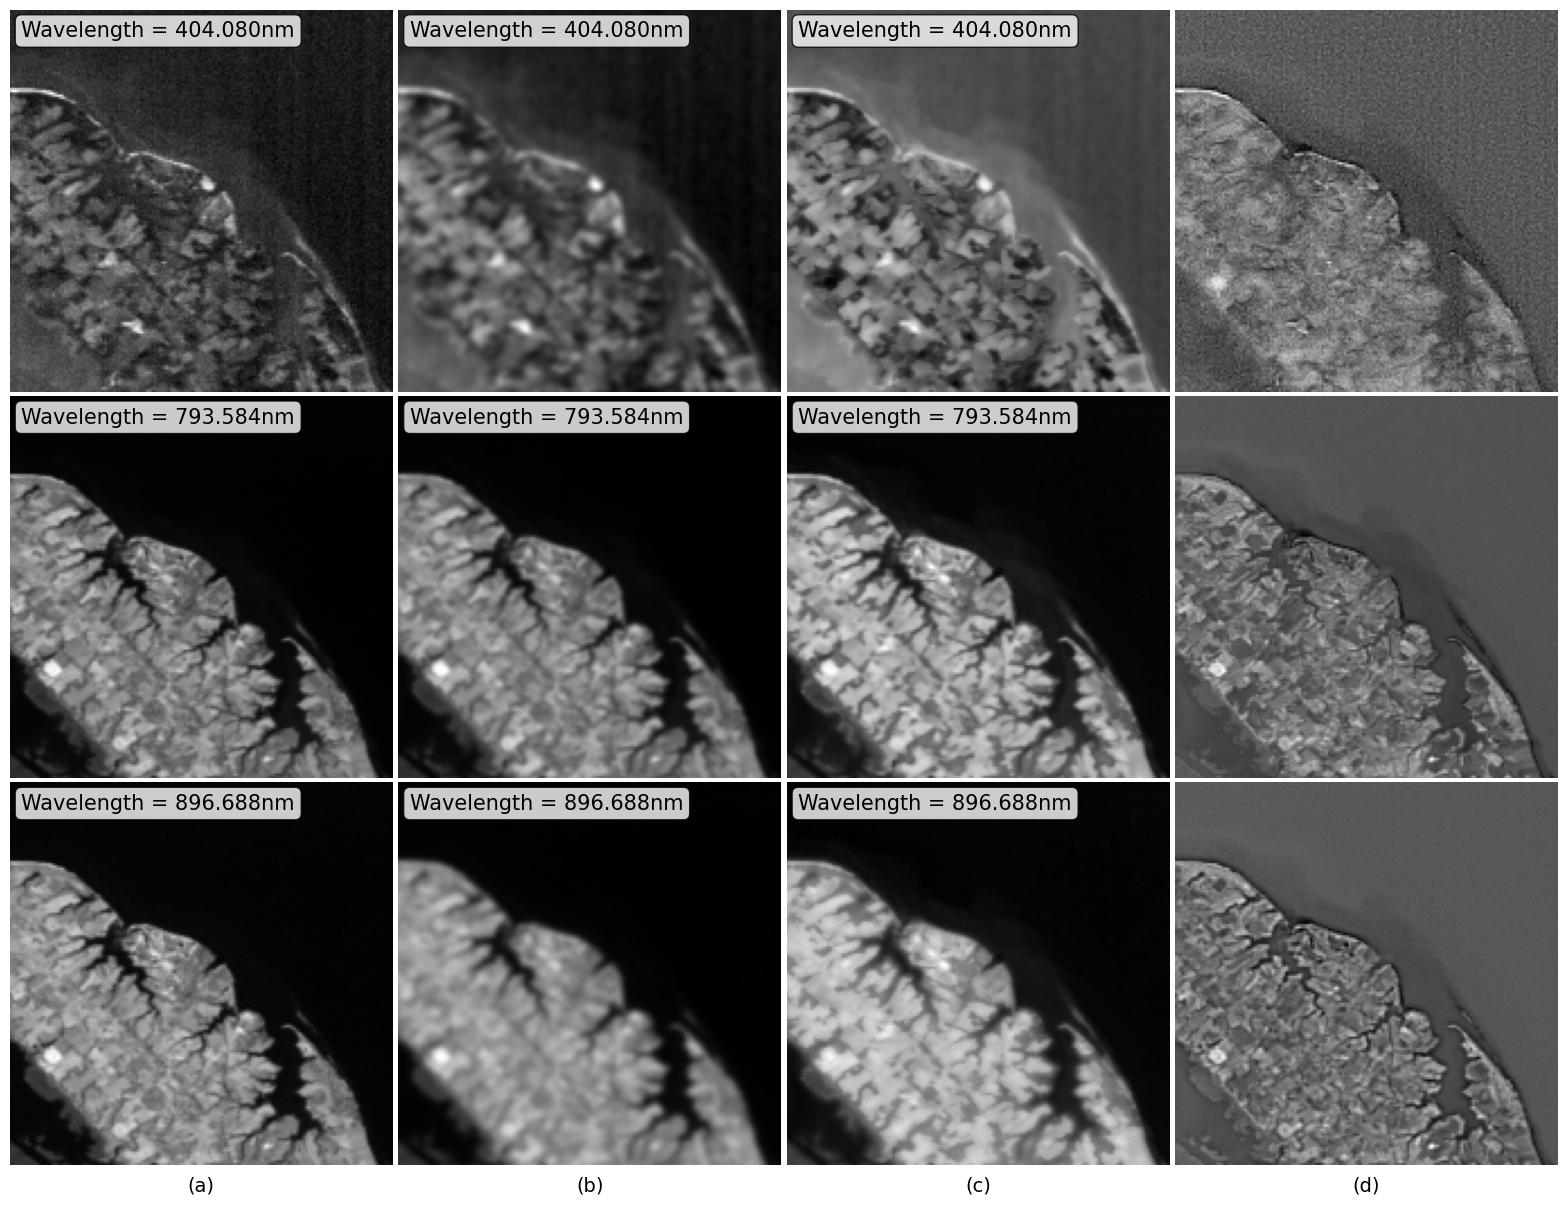

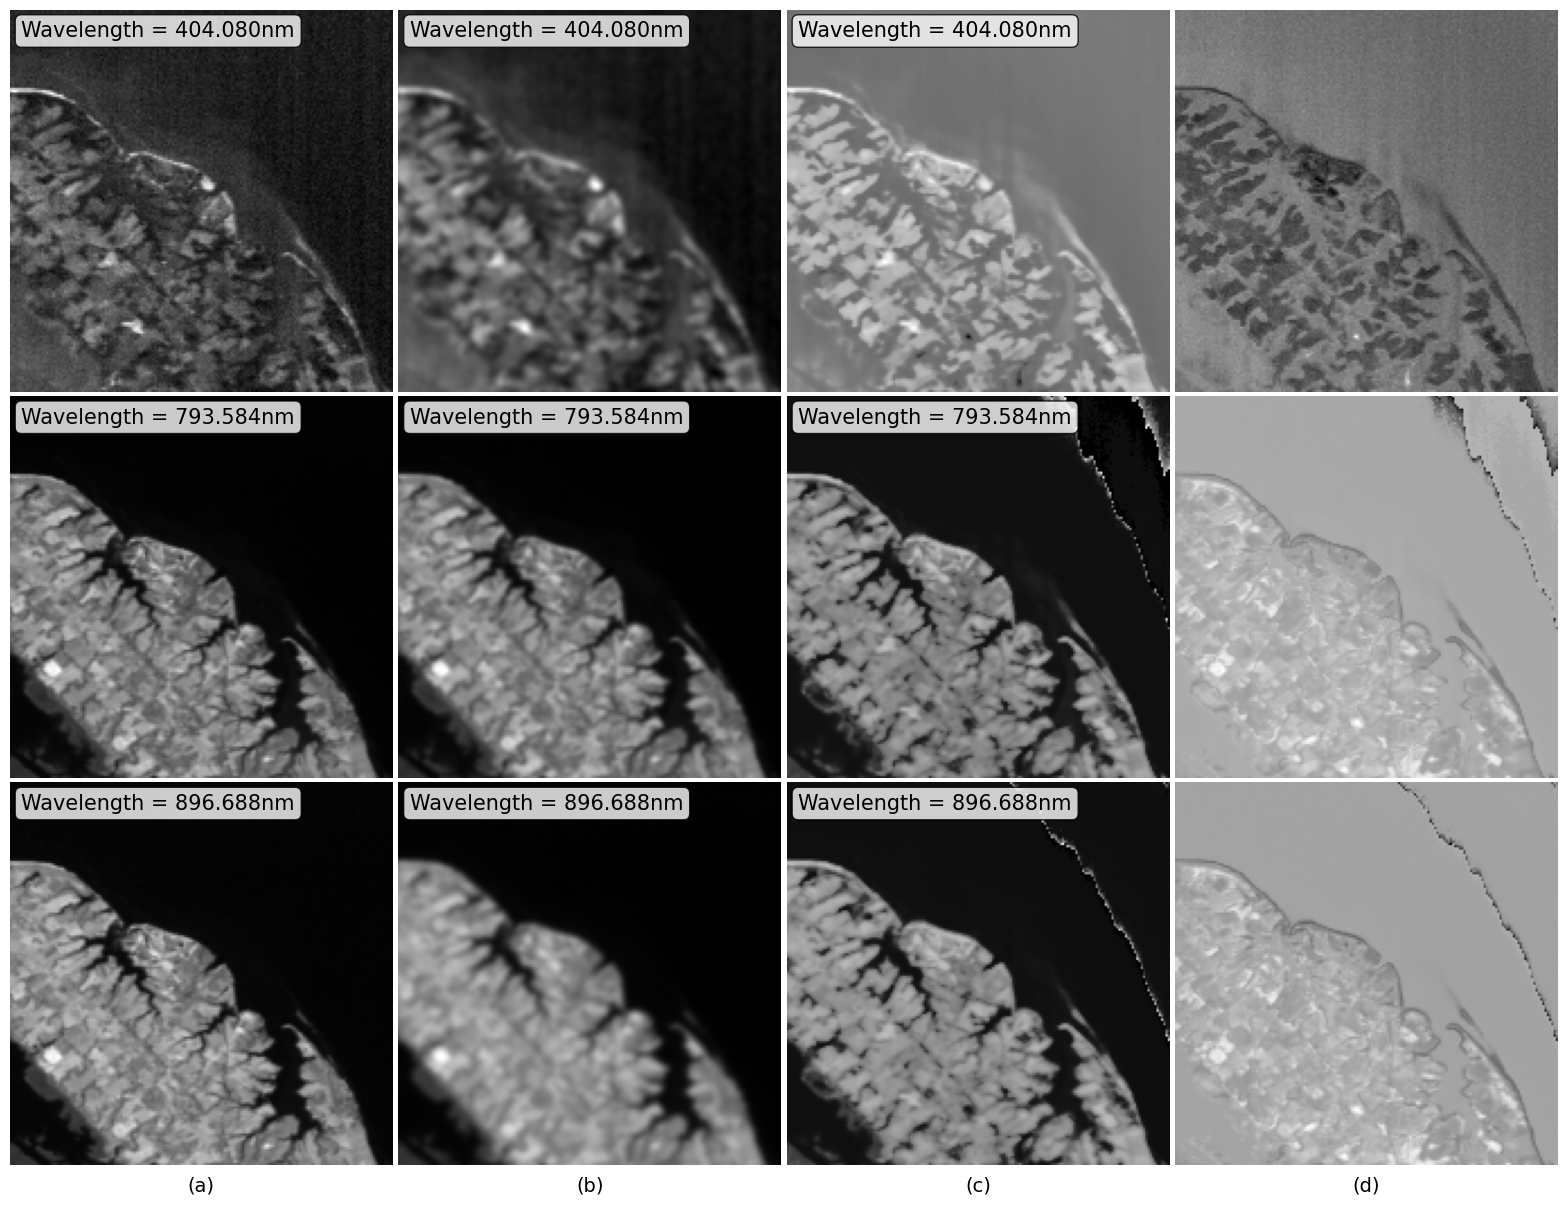

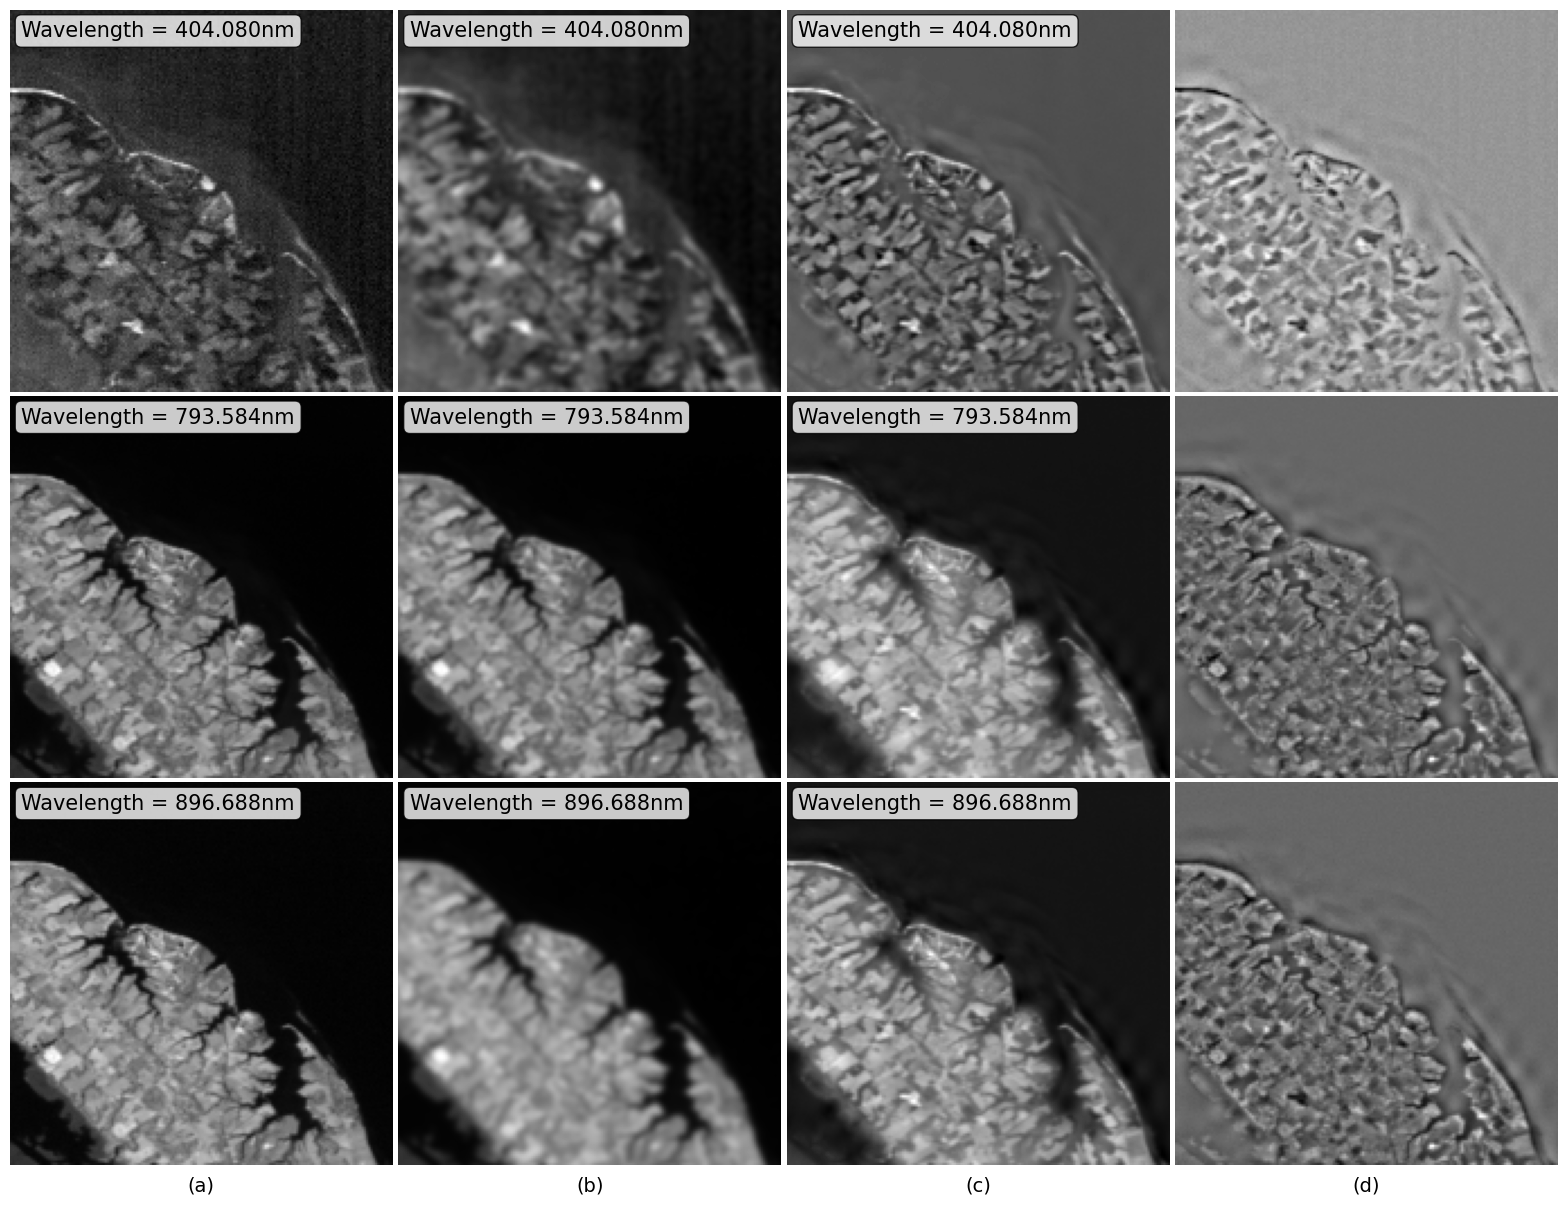

In [34]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

def extract_patch(the_path, patch_n, patch_size, quality):
    data = np.load(the_path)
    if quality == None:
        image = data
    else:
        image = data[quality]
    grid_width = 3
    patch_width, patch_height = patch_size
    patch_n -= 1  # Adjust the patch number to be zero-indexed
    x = (patch_n % grid_width) * patch_width
    y = (patch_n // grid_width) * patch_height
    # Ensure the rectangle is within the bounds of the image
    x = min(x, image.shape[1] - patch_width)
    y = min(y, image.shape[0] - patch_height)
    return image[y:y+patch_height, x:x+patch_width]

def visualize_cube(blur_patch_path, fus_patch_path, out, num):
    patch_size = (170, 170)
    blurred_patch = extract_patch(blur_patch_path, num, patch_size, 'blurred_cube')
    ref_patch = extract_patch(blur_patch_path, num, patch_size, 'original_cube')
    fused_patch = extract_patch(fus_patch_path, num, patch_size, None)
        
    patches = {
        'Original': ref_patch,
        "Blurred": blurred_patch,
        "Sharp": fused_patch,
    }

    difference = ref_patch - fused_patch
    
    bands = [0, 67, 86]
    wavelengths = {0: '404.080nm', 67: '793.584nm', 86: '896.688nm'}
    column_labels = ['(a)', '(b)', '(c)', '(d)']  # Updated to include (d)
    fig, ax = plt.subplots(len(bands), len(patches) + 1, figsize=(20, 15))  # Adjusted for an additional column

    for j, (name, cube) in enumerate(patches.items()):
        for i, band in enumerate(bands):
            subcubeframe = cube[:, :, band]            
            ax[i, j].imshow(subcubeframe, cmap='gray')
            ax[i, j].axis('off')
            title = f"Wavelength = {wavelengths[band]}"
            ax[i, j].text(0.03, 0.97, title, transform=ax[i, j].transAxes, fontsize=15, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    for i, band in enumerate(bands):
        diff_frame = difference[:, :, band]
        ax[i, len(patches)].imshow(diff_frame, cmap='gray')
        ax[i, len(patches)].axis('off')

    for j, label in enumerate(column_labels):
        ax[-1, j].text(0.5, -0.03, label, transform=ax[-1, j].transAxes, fontsize=14, verticalalignment='top', ha='center')

    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.savefig(out, format='pdf', bbox_inches='tight')
    plt.show()

blurred_path_classic = '/home/kimado/master/HYPSO-1/hico_data/blurred_data/H2010026150016.L1B_ISS.nc_blurred.npz'

sharp_dict = {'cs'        : '/home/kimado/master/HYPSO-1/hico_data/sharp_data/component_substitution_H2010026150016.L1B_ISS.nc_blurred.npz.npy',
            'laplacian'   : '/home/kimado/master/HYPSO-1/hico_data/sharp_data/laplacian_fo5_H2010026150016.L1B_ISS.nc_blurred.npz.npy',
                'wavelet' :  '/home/kimado/master/HYPSO-1/hico_data/sharp_data/wavelet_coif4_lvl3_regular_H2010026150016.L1B_ISS.nc_blurred.npz.npy'}

for key in sharp_dict:
    out = f'/home/kimado/master/HYPSO-1/fig/bands/016-{key}-bands.pdf'
    visualize_cube(blurred_path_classic, sharp_dict[key], out, 11)
